# Inversion tests

In [16]:
import numpy as np
import scipy as sp
import time
import matplotlib.pyplot as plt

#Adding personal libraries
import sys
sys.path.append("/net/server/homes/sep/ettore/research/packages/acoustic_isotropic_operators/local/lib/python/")
sys.path.append("/sep/rahul/cplex/CPLEX_Studio1271/cplex/python/3.5/x86-64_linux/")
import cplex as cp
import genericIO
import SepVector

In [2]:
vec1 = SepVector.getSepVector(ns=[100,200])
vec1.rand()
arr = vec1.getNdArray()

## TODO List

### 0. Find a starting model so that Marmousi converges

### 1. FWI with PEF
- Bob's code to find PEF forward & adjoint operators
- We can test FWI
- Hopefully FWI converges faster
- If we have time, try different regularizations
- Constrained versions of the problem

In [3]:
# Functions that we need

def apply_PEF(x, adj):
    """
    Apply PEF forward and adjoint
    """
    raise NotImplementedError

def born_adjoint(x):
    """
    Apply Born adjoint
    """
    raise NotImplementedError

# We already have linesearch




## Accelerated Gradient Descent

In [4]:
def nesterov_accl_grad_descent(grad_f, beta, x0, niter, gtol=1e-10):
    
    """
    This function implements Nesterov's accelerated gradient descent which
    has the property that for convex "beta-smooth" functions, the convergence
    rate guarantee is O(1/t^2), where t is the number of iterations.
    
    Note: This implementation cannot handle constraints
    """
    
    obj_list = []
    gnorm_list = []
    
    x = x0
    y = x0
    y_old = x0
    
    lambda_old = 1.0
    
    for i in range(1, niter + 1):
        
        lambda_new = 0.5 * (1 + np.sqrt(1 + 4 * (lambda_old ** 2)))
        gamma = (1.0 - lambda_old) / lambda_new
        lambda_old = lambda_new
        
        g, f = grad_f.evaluate(x)
        gnorm = np.linalg.norm(g)
        
        obj_list.append(f)
        gnorm_list.append(gnorm)
        
        if gnorm < gtol:
            break
        
        y_old = y_old * 0 + y
        y = x - (1 / beta) * g
        x = (1 - gamma) * y + gamma * y_old
    
    return x, obj_list, gnorm_list

### Run accelerated gradient descent on an example

In [5]:
class grad_quadratic(object):
    
    def __init__(self, n, mat, b):
        
        self.__n = n
        self.__mat = mat
        self.__b = b
    
    def evaluate(self, x):
        
        obj = 0.5 * np.dot(np.transpose(x), np.dot(self.__mat, x)) + np.dot(np.transpose(x), self.__b)
        grad = np.dot(self.__mat, x) + self.__b
        
        return grad, obj

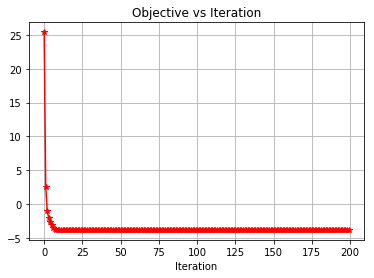

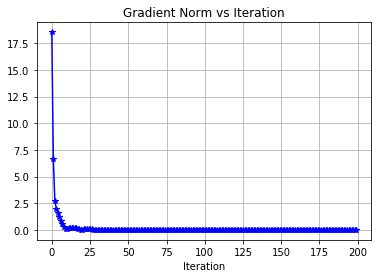

In [6]:
n = 10
eigs = np.asarray([np.random.uniform(1, 10) for _ in range(n)]) # This controls value of beta
A = np.diag(eigs)
b = np.transpose(np.asarray([np.random.randn() for _ in range(n)]))

grad_func1 = grad_quadratic(n=n, mat=A, b=b)
x0 = np.transpose(np.asarray([np.random.randn() for _ in range(n)]))
xsol, obj_list, gnorm_list = nesterov_accl_grad_descent(grad_f=grad_func1, beta=10, x0=x0, niter=200, gtol=1e-10)

%matplotlib inline

plt.figure()
plt.plot(obj_list, '-r*')
plt.title("Objective vs Iteration")
plt.xlabel("Iteration")
plt.grid()

plt.figure()
plt.plot(gnorm_list, '-b*')
plt.title("Gradient Norm vs Iteration")
plt.xlabel("Iteration")
plt.grid()

## Alternating Projection Method

### DO NOT USE IN PRODUCTION CODE, DO NOT DELETE (KEEP FOR EDUCATIONAL PURPOSES)

In [7]:
def box_der_altproj_2D(x, xmin, xmax, epsilon_min=0.0, epsilon_max=0.0, tol=1e-6):
    
    """
    This method takes a point x and projects it onto the intersection
    of the following sets:
    
    1. xmin <= x <= xmax
    2. epsilon_min <= D1x <= epsilon_max (derivative along 1st axis)
    3. epsilon_min <= D2x <= epsilon_max (derivative along 2nd axis)
    
    @params
    xmin, xmax: 2D numpy arrays of floats
    epsilon_min, epsilon_max: scalars (floats)
    """
    
    # Check parameters
    if epsilon_min > epsilon_max:
        raise ValueError("Violated constraint: epsilon_min <= epsilon_max")
    
    # Allocate temporary variables
    x1 = np.copy(x)
    x2 = np.copy(x)
    
    # Get shape information
    n1 = x.shape[0]
    n2 = x.shape[1]
    
    # Variable for number of iterations
    niter = 0
    
    while 1:
        
        # Project on set 1
        np.clip(x1, xmin, xmax, out=x2)
        
        # Project on set 2
        for i1 in range(n1):
            for i2 in range(n2 - 1):
                
                if (x2[i1, i2] - x2[i1, i2+1]) > epsilon_max:
                    f = 0.5 * (epsilon_max - x2[i1, i2] + x2[i1, i2+1])
                    x2[i1, i2] += f
                    x2[i1, i2+1] -= f

                elif (x2[i1, i2] - x2[i1, i2+1]) < epsilon_min:
                    f = 0.5 * (epsilon_min - x2[i1, i2] + x2[i1, i2+1])
                    x2[i1, i2] += f
                    x2[i1, i2+1] -= f
        
        # Project on set 3
        for i1 in range(n1 - 1):
            for i2 in range(n2):
                
                if (x2[i1, i2] - x2[i1+1, i2]) > epsilon_max:
                    f = 0.5 * (epsilon_max - x2[i1, i2] + x2[i1+1, i2])
                    x2[i1, i2] += f
                    x2[i1+1, i2] -= f

                elif (x2[i1, i2] - x2[i1+1, i2]) < epsilon_min:
                    f = 0.5 * (epsilon_min - x2[i1, i2] + x2[i1+1, i2])
                    x2[i1, i2] += f
                    x2[i1+1, i2] -= f
                
        # Update iteration count
        niter += 1
        
        # Check for convergence
        d1 = np.amax(np.abs(x1 - x2))
        if d1 < tol:
            return x2, niter
        
        # Update x1
        x1 *= 0
        x1 += x2

## Alternating Projection Method (Vectorized)

In [8]:
def box_der_altproj_2D_vectorized(x, xmin, xmax, epsilon_min=0.0, epsilon_max=0.0, tol=1e-6):
    
    """
    This method takes a point x and projects it onto the intersection
    of the following sets:
    
    1. xmin <= x <= xmax
    2. epsilon_min <= D1x <= epsilon_max (derivative along 1st axis)
    3. epsilon_min <= D2x <= epsilon_max (derivative along 2nd axis)
    
    @params
    xmin, xmax: 2D numpy arrays of floats
    epsilon_min, epsilon_max: scalars (floats)
    """
    
    # Check parameters
    if epsilon_min > epsilon_max:
        raise ValueError("Violated constraint: epsilon_min <= epsilon_max")
    
    # Allocate temporary variables
    x1 = np.copy(x)
    x2 = np.copy(x)
    
    # Get shape information
    n1 = x.shape[0]
    n2 = x.shape[1]
    
    # Precompute to save multiplications
    delta_max = 0.5 * epsilon_max
    delta_min = 0.5 * epsilon_min
    
    # Variable for number of iterations
    niter = 0
    
    while 1:
        
        # Project on set 1
        np.clip(x1, xmin, xmax, out=x2)
        
        # Project on set 2
        for i2 in range(n2 - 1):
            
            f = 0.5 * (x2[:, i2] - x2[:, i2+1])
            f1 = delta_max - f
            np.clip(f1, a_min=None, a_max=0, out=f1)
            f2 = delta_min - f
            np.clip(f2, a_min=0, a_max=None, out=f2)
            f1 += f2
            
            x2[:, i2] += f1
            x2[:, i2+1] -= f1
        
        # Project on set 3
        for i1 in range(n1 - 1):
            
            f = 0.5 * (x2[i1, :] - x2[i1+1, :])
            f1 = delta_max - f
            np.clip(f1, a_min=None, a_max=0, out=f1)
            f2 = delta_min - f
            np.clip(f2, a_min=0, a_max=None, out=f2)
            f1 += f2
            
            x2[i1, :] += f1
            x2[i1+1, :] -= f1
                
        # Update iteration count
        niter += 1
        
        # Check for convergence
        d1 = np.amax(np.abs(x1 - x2))
        if d1 < tol:
            return x2, niter
        
        # Update x1
        x1 *= 0
        x1 += x2

### Test the projection method
#### Example 1 (Random Noise)

Time taken =  0.95 sec, Number of alternating projections = 61


Text(0.5,1,'Projected')

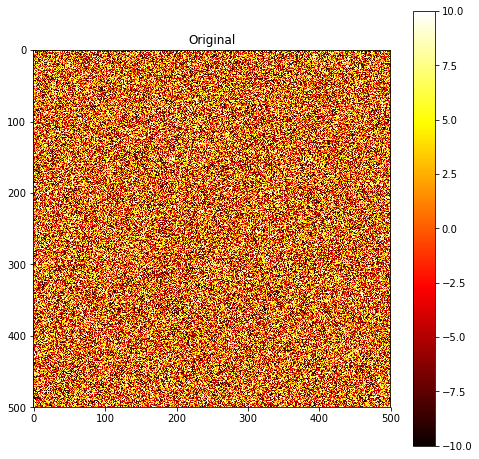

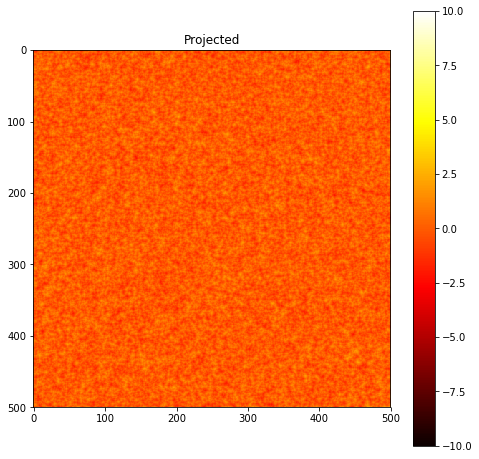

In [9]:
n1 = 500
n2 = 500

xmin = -3.0
xmax = 3.0
low = -10.0
high = 10.0

x = np.random.uniform(low=low, high=high, size=(n1, n2))
x1 = np.zeros((n1, n2)) + xmin
x2 = np.zeros((n1, n2)) + xmax

t_start = time.time()
y, niter = box_der_altproj_2D_vectorized(x=x, xmin=x1, xmax=x2, epsilon_min=-0.5, epsilon_max=0.5)
t_end = time.time()

print("Time taken = " + "{:5.2f}".format(t_end - t_start) + " sec, Number of alternating projections = " + str(niter))

%matplotlib inline

plt.figure(figsize=(8, 8))
plt.imshow(x, cmap="hot", vmin=low, vmax=high)
plt.colorbar()
plt.title("Original")

plt.figure(figsize=(8, 8))
plt.imshow(y, cmap="hot", vmin=low, vmax=high)
plt.colorbar()
plt.title("Projected")

#### Example 2 (Sharp Interface)

Time taken =  2.67 sec, Number of alternating projections = 164


Text(0.5,1,'Projected')

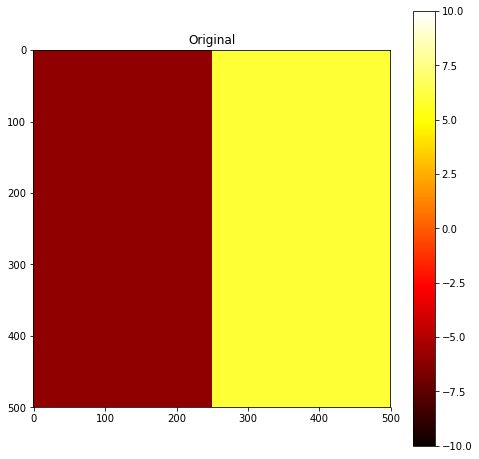

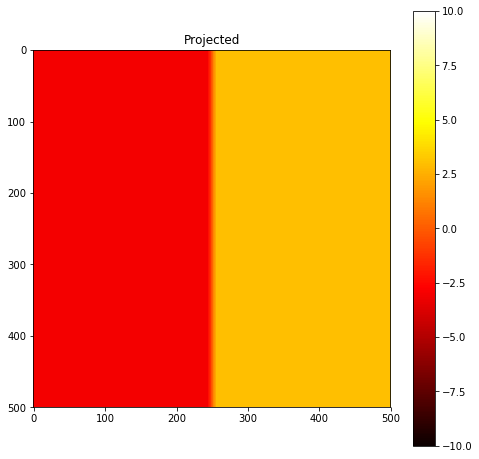

In [10]:
n1 = 500
n2 = 500

xmin = -3.0
xmax = 3.0
low = -10.0
high = 10.0

x = np.zeros((n1, n2))
x[:, 0: int(n2/2)] = -6.0
x[:, int(n2/2): n2] = 6.0

x1 = np.zeros((n1, n2)) + xmin
x2 = np.zeros((n1, n2)) + xmax

t_start = time.time()
y, niter = box_der_altproj_2D_vectorized(x=x, xmin=x1, xmax=x2, epsilon_min=-0.5, epsilon_max=0.5)
t_end = time.time()

print("Time taken = " + "{:5.2f}".format(t_end - t_start) + " sec, Number of alternating projections = " + str(niter))

%matplotlib inline

plt.figure(figsize=(8, 8))
plt.imshow(x, cmap="hot", vmin=low, vmax=high)
plt.colorbar()
plt.title("Original")

plt.figure(figsize=(8, 8))
plt.imshow(y, cmap="hot", vmin=low, vmax=high)
plt.colorbar()
plt.title("Projected")

#### Example 3 (Thin Reflector)

Time taken =  0.67 sec, Number of alternating projections = 43


Text(0.5,1,'Projected')

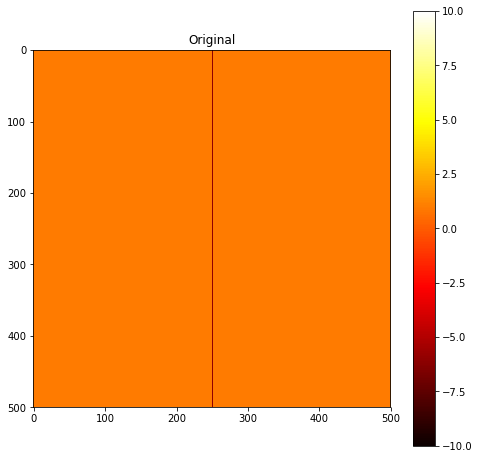

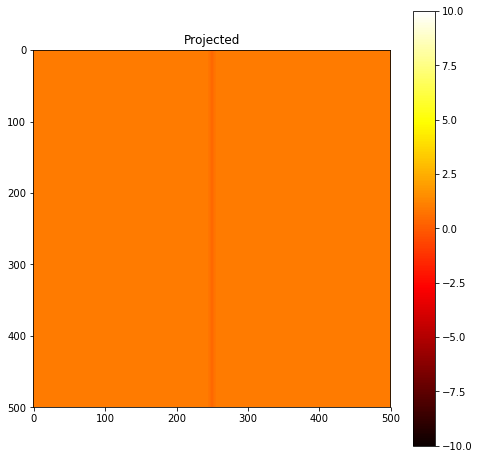

In [11]:
n1 = 500
n2 = 500

xmin = -3.0
xmax = 3.0
low = -10.0
high = 10.0

x = np.zeros((n1, n2)) + 1
x[:, int(n2/2)] = -6.0

x1 = np.zeros((n1, n2)) + xmin
x2 = np.zeros((n1, n2)) + xmax

t_start = time.time()
y, niter = box_der_altproj_2D_vectorized(x=x, xmin=x1, xmax=x2, epsilon_min=-0.1, epsilon_max=0.1)
t_end = time.time()

print("Time taken = " + "{:5.2f}".format(t_end - t_start) + " sec, Number of alternating projections = " + str(niter))

%matplotlib inline

plt.figure(figsize=(8, 8))
plt.imshow(x, cmap="hot", vmin=low, vmax=high)
plt.colorbar()
plt.title("Original")

plt.figure(figsize=(8, 8))
plt.imshow(y, cmap="hot", vmin=low, vmax=high)
plt.colorbar()
plt.title("Projected")

## Read Marmousi Model

(851, 176)


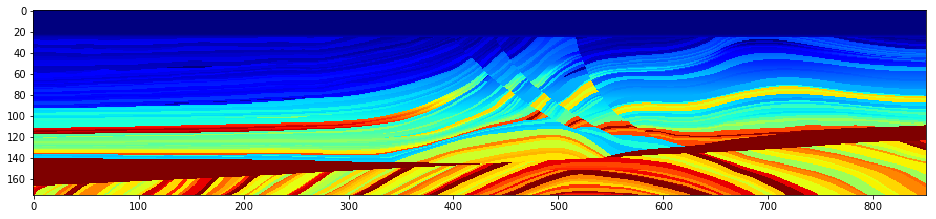

In [11]:
#Reading Marmousi model
Marm_vec = genericIO.defaultIO.getVector("Dat/MarmTrue.H")
marm  = Marm_vec.getNdArray()
print(marm.shape)
plt.figure(figsize=(16, 48))
plt.imshow(marm.T, cmap="jet", vmin=1.5, vmax=4.5)

## Smoothing Tests on Marmousi

#### Expected runtime ~ 230 s

In [ ]:
t_start = time.time()
marm_smooth, niter = box_der_altproj_2D_vectorized(x=marm, xmin=1.0, xmax=5.0, epsilon_min=-0.01, epsilon_max=0.01, tol=1e-6)
t_end = time.time()

print("Time taken = " + "{:5.2f}".format(t_end - t_start) + " sec, Number of alternating projections = " + str(niter))

plt.figure(figsize=(16, 48))
plt.imshow(marm.T, cmap="jet", vmin=1.5, vmax=4.5)
plt.title("Original Marmousi")

plt.figure(figsize=(16, 48))
plt.imshow(marm_smooth.T, cmap="jet", vmin=1.5, vmax=4.5)
plt.title("Smoothed Marmousi")

#### Expected runtime ~ 110 s

In [ ]:
t_start = time.time()
marm_smooth, niter = box_der_altproj_2D_vectorized(x=marm, xmin=1.0, xmax=5.0, epsilon_min=-0.02, epsilon_max=0.02, tol=1e-6)
t_end = time.time()

print("Time taken = " + "{:5.2f}".format(t_end - t_start) + " sec, Number of alternating projections = " + str(niter))

plt.figure(figsize=(16, 48))
plt.imshow(marm.T, cmap="jet", vmin=1.5, vmax=4.5)
plt.title("Original Marmousi")

plt.figure(figsize=(16, 48))
plt.imshow(marm_smooth.T, cmap="jet", vmin=1.5, vmax=4.5)
plt.title("Smoothed Marmousi")

#### Expected runtime ~ 30 s

Time taken = 26.18 sec, Number of alternating projections = 2172


Text(0.5,1,'Smoothed Marmousi')

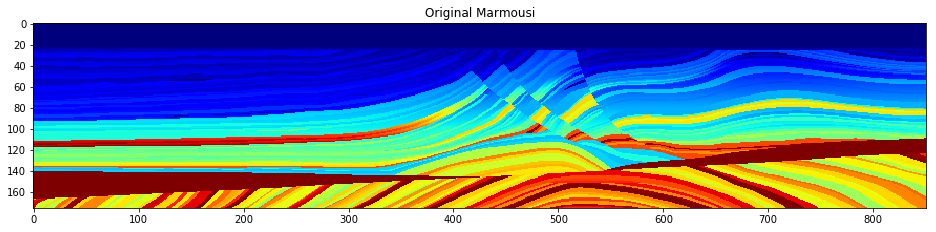

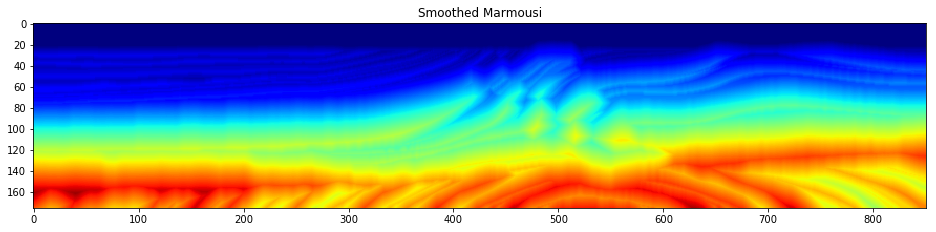

In [12]:
t_start = time.time()
marm_smooth, niter = box_der_altproj_2D_vectorized(x=marm, xmin=1.0, xmax=5.0, epsilon_min=-0.03, epsilon_max=0.03, tol=1e-6)
t_end = time.time()

print("Time taken = " + "{:5.2f}".format(t_end - t_start) + " sec, Number of alternating projections = " + str(niter))

plt.figure(figsize=(16, 48))
plt.imshow(marm.T, cmap="jet", vmin=1.5, vmax=4.5)
plt.title("Original Marmousi")

plt.figure(figsize=(16, 48))
plt.imshow(marm_smooth.T, cmap="jet", vmin=1.5, vmax=4.5)
plt.title("Smoothed Marmousi")

#### Expected runtime ~ 17 s

Time taken = 14.49 sec, Number of alternating projections = 1209


Text(0.5,1,'Smoothed Marmousi')

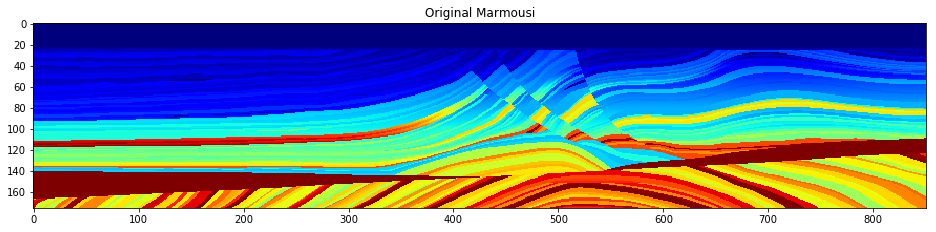

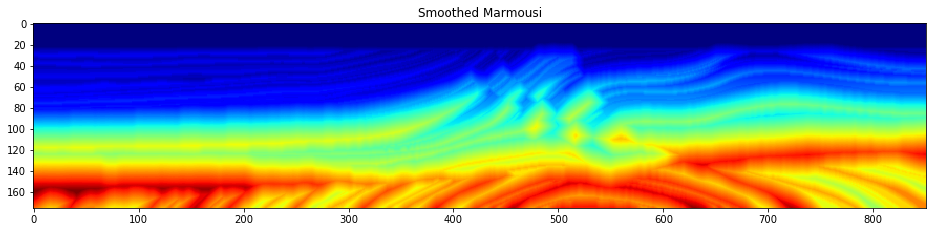

In [13]:
t_start = time.time()
marm_smooth, niter = box_der_altproj_2D_vectorized(x=marm, xmin=1.0, xmax=5.0, epsilon_min=-0.04, epsilon_max=0.04, tol=1e-6)
t_end = time.time()

print("Time taken = " + "{:5.2f}".format(t_end - t_start) + " sec, Number of alternating projections = " + str(niter))

plt.figure(figsize=(16, 48))
plt.imshow(marm.T, cmap="jet", vmin=1.5, vmax=4.5)
plt.title("Original Marmousi")

plt.figure(figsize=(16, 48))
plt.imshow(marm_smooth.T, cmap="jet", vmin=1.5, vmax=4.5)
plt.title("Smoothed Marmousi")

#### Expected runtime ~ 12 s

Time taken = 10.80 sec, Number of alternating projections = 881


Text(0.5,1,'Smoothed Marmousi')

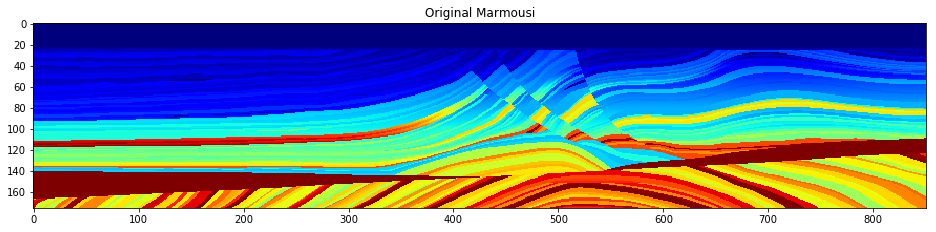

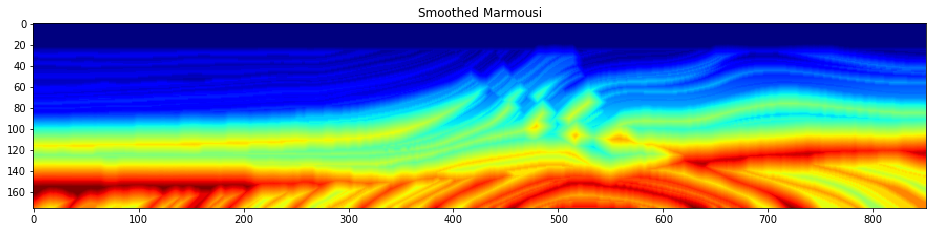

In [15]:
t_start = time.time()
marm_smooth, niter = box_der_altproj_2D_vectorized(x=marm, xmin=1.0, xmax=5.0, epsilon_min=-0.05, epsilon_max=0.05, tol=1e-6)
t_end = time.time()

print("Time taken = " + "{:5.2f}".format(t_end - t_start) + " sec, Number of alternating projections = " + str(niter))

plt.figure(figsize=(16, 48))
plt.imshow(marm.T, cmap="jet", vmin=1.5, vmax=4.5)
plt.title("Original Marmousi")

plt.figure(figsize=(16, 48))
plt.imshow(marm_smooth.T, cmap="jet", vmin=1.5, vmax=4.5)
plt.title("Smoothed Marmousi")

## Tests on Sigsbee

(1067, 601)


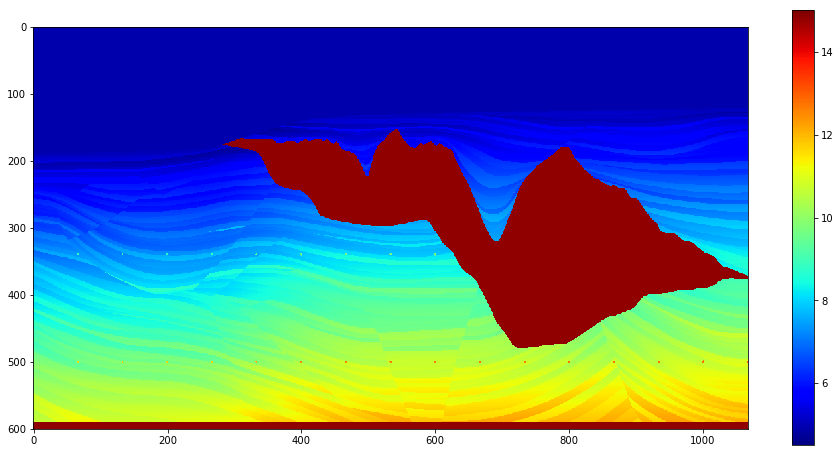

In [17]:
sigs = np.load("/net/server/homes/sep/rahul/Research/rahul_ettore_tests/Dat/sigsbee.npz")
sigs = sigs["arr_0"]
sigs /= 1000.0
print(sigs.shape)

plt.figure(figsize=(16, 8))
plt.imshow(sigs.T, cmap="jet", vmin=4.5, vmax=15)
plt.colorbar()

Time taken =  1.11 sec, Number of alternating projections = 27


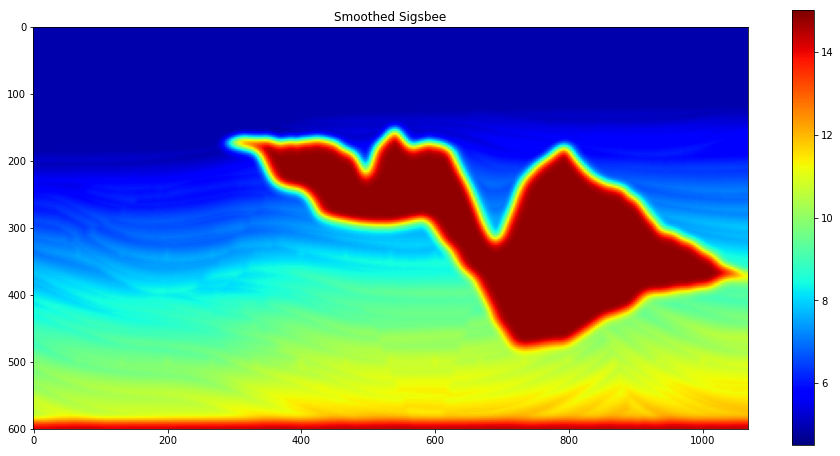

In [14]:
t_start = time.time()
sigs_smooth, niter = box_der_altproj_2D_vectorized(x=sigs, xmin=4.5, xmax=15, epsilon_min=-0.02, epsilon_max=0.02, tol=1e-1)
t_end = time.time()

print("Time taken = " + "{:5.2f}".format(t_end - t_start) + " sec, Number of alternating projections = " + str(niter))

plt.figure(figsize=(16, 8))
plt.imshow(sigs_smooth.T, cmap="jet", vmin=4.5, vmax=15)
plt.title("Smoothed Sigsbee")
plt.colorbar()

## CPLEX Code (Seems to be slow)

In [18]:
def box_der_cplex(x, xmin, xmax, epsilon_min=0.0, epsilon_max=0.0):
    
    """
    This method takes a point x and projects it onto the intersection
    of the following sets:
    
    1. xmin <= x <= xmax
    2. epsilon_min <= D1x <= epsilon_max (derivative along 1st axis)
    3. epsilon_min <= D2x <= epsilon_max (derivative along 2nd axis)
    
    @params
    xmin, xmax: 2D numpy arrays of floats
    epsilon_min, epsilon_max: scalars (floats)
    """
    
    # Check parameters
    if epsilon_min > epsilon_max:
        raise ValueError("Violated constraint: epsilon_min <= epsilon_max")
    
    # Allocate temporary variables
    x1 = np.copy(x)
    x2 = np.copy(x)
    
    # Get shape information
    n1 = x.shape[0]
    n2 = x.shape[1]
    
    # Flatten arrays
    x_flatten = x.ravel()
    xmin_flatten = xmin.ravel()
    xmax_flatten = xmax.ravel()
    
    # Instantiate Cplex object with the attributes
    problem = cp.Cplex()
    problem.objective.set_sense(problem.objective.sense.minimize)
    # problem.parameters.optimalitytarget.set(problem.parameters.optimalitytarget.values.optimal_global)
    
    # Set up variable names and add them as continuous variables with bounds
    var_names = ["x" + str(i1) + "_" + str(i2) for i1 in range(n1) for i2 in range(n2)]
    var_types = [problem.variables.type.continuous for _ in var_names]
    problem.variables.add(names=var_names, types=var_types, lb=xmin_flatten.tolist(), ub=xmax_flatten.tolist())
    problem.set_problem_type(problem.problem_type.QP)
    
    # Set linear constraints (Derivative along first axis)
    problem.linear_constraints.add(
        lin_expr = [
            cp.SparsePair(
                ind = ["x" + str(i1) + "_" + str(i2), "x" + str(i1+1) + "_" + str(i2)], 
                val = [-1.0, 1.0]
            ) for i1 in range(n1 - 1) for i2 in range(n2)
        ],
        senses = ["R" for _ in range(n1 - 1) for _ in range(n2)],
        rhs = [epsilon_min for _ in range(n1 - 1) for _ in range(n2)],
        range_values = [(epsilon_max - epsilon_min) for _ in range(n1 - 1) for _ in range(n2)]
    )
    
    # Set linear constraints (Derivative along second axis)
    problem.linear_constraints.add(
        lin_expr = [
            cp.SparsePair(
                ind = ["x" + str(i1) + "_" + str(i2), "x" + str(i1) + "_" + str(i2+1)], 
                val = [-1.0, 1.0]
            ) for i2 in range(n2 - 1) for i1 in range(n1)
        ],
        senses = ["R" for _ in range(n2 - 1) for _ in range(n1)],
        rhs = [epsilon_min for _ in range(n2 - 1) for _ in range(n1)],
        range_values = [(epsilon_max - epsilon_min) for _ in range(n2 - 1) for _ in range(n1)]
    )
    
    # Set quadratic objective
    problem.objective.set_quadratic([1.0 for _ in range(len(var_names))])
    
    # Set linear objective
    problem.objective.set_linear([(i, -1.0 * x_flatten[i]) for i in range(len(var_names))])
    
    # Solve
    problem.parameters.qpmethod.set(problem.parameters.qpmethod.values.barrier)
    problem.parameters.barrier.convergetol.set(1e-2)
    
    problem.set_log_stream(None)
    problem.set_error_stream(None)
    problem.set_warning_stream(None)
    problem.set_results_stream(None)

    problem.solve()
    
    # Get solution
    sol = problem.solution.get_values(var_names)
    sol = np.asarray(sol)
    sol = np.reshape(sol, newshape=(n1, n2))
    
    return sol

Time taken = 65.79


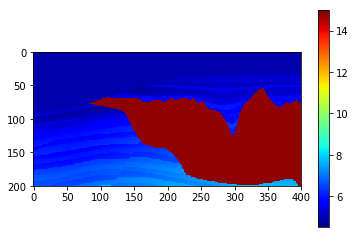

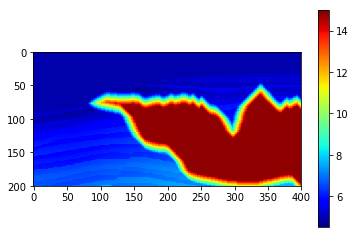

In [20]:
sigs1 = sigs[200:600, 100:300]

plt.figure()
plt.imshow(sigs1.T, cmap="jet", vmin=4.5, vmax=15)
plt.colorbar()

xmin_sigs = sigs1 * 0 + 4.5
xmax_sigs = sigs1 * 0 + 15.0

t_start = time.time()
sigs1_smooth = box_der_cplex(x=sigs1, xmin=xmin_sigs, xmax=xmax_sigs, epsilon_min=-0.5, epsilon_max=0.5)
t_end = time.time()

print("Time taken = " + "{:5.2f}".format(t_end - t_start))

plt.figure()
plt.imshow(sigs1_smooth.T, cmap="jet", vmin=4.5, vmax=15)
plt.colorbar()